# Social status analysis
In this document, we will try to 

In [1]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

combined_df = pd.concat(df_list)

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1206/1328668253.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


#  We now move on to use helpers as a proxy for weatlh and see if different families take different household strategies.

In [2]:
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_census_data(df_list: List[pd.DataFrame], county_names: List[str]) -> pd.DataFrame:
    """
    Optimizes multiple census dataframes by converting data types and adding computed columns
    for household classification and helper analysis. Handles historical Danish census data
    specifics and combines the dataframes into a single optimized dataset.
    
    Args:
        df_list: List of raw census DataFrames with household data
        county_names: List of county names corresponding to each DataFrame
        
    Returns:
        Combined DataFrame with optimized data types and additional computed columns
    """
    # First ensure each dataframe has its county information
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    
    # Combine all dataframes
    combined_df = pd.concat(df_list, ignore_index=True)
    optimized_df = combined_df.copy()
    
    # Convert categorical columns and handle historical Danish variations
    # We use 'ukendt' (unknown) as it's the period-appropriate Danish term
    cat_columns = ['household_position', 'marital_status', 'sex', 'event_county']
    optimized_df[cat_columns] = optimized_df[cat_columns].fillna('ukendt').astype('category')
    
    # Convert age to numeric, marking unknown ages as -1
    # Age data in historical censuses can be inconsistent, so we handle it carefully
    optimized_df['age'] = pd.to_numeric(optimized_df['age'], errors='coerce').fillna(-1)
    
    # Compute helper-related flags using period-appropriate Danish terms
    # These terms cover various ways servants and helpers were recorded in Danish censuses
    helper_terms = [
        'tjeneste', 'tjener', 'tjenestepige', 'tjenestekarl',
        'pige', 'karl', 'husholderske'
    ]
    optimized_df['is_helper'] = optimized_df['household_position'].str.contains(
        '|'.join(helper_terms), 
        case=False, 
        na=False
    )
    
    # Compute demographic flags considering historical Danish marriage terms
    marriage_terms = ['gift', 'ugift']
    optimized_df['is_married'] = optimized_df['marital_status'].str.match(
        '|'.join(marriage_terms), 
        case=False, 
        na=False
    )
    
    # Handle widowed status with historical Danish terms
    widow_terms = ['enke', 'enkemand', 'enkestand']
    optimized_df['is_widowed'] = optimized_df['marital_status'].str.contains(
        '|'.join(widow_terms), 
        case=False, 
        na=False
    )
    
    # Age-based classifications following historical Danish practices
    optimized_df['is_adult'] = optimized_df['age'] >= 15
    optimized_df['is_child'] = (optimized_df['age'] < 15) & (optimized_df['age'] >= 0)
    
    # Gender classification with historical Danish terms
    optimized_df['is_male'] = optimized_df['sex'].str.contains('m|mand', case=False, na=False)
    
    # Calculate helper counts per household
    # This creates our proxy for social status/wealth
    helper_counts = optimized_df.groupby('household_id')['is_helper'].sum()
    optimized_df = optimized_df.merge(
        helper_counts.rename('household_helper_count'),
        left_on='household_id',
        right_index=True
    )
    
    # Assign social class based on helper count
    # The thresholds are based on historical studies of servant-keeping patterns
    optimized_df['social_class'] = pd.cut(
        optimized_df['household_helper_count'],
        bins=[-np.inf, 0, 2, np.inf],
        labels=['Working Class', 'Middle Class', 'Upper Class']
    )
    
    return optimized_df

def analyze_households_by_county(
    df_list: List[pd.DataFrame],
    county_names: List[str]
) -> Dict[str, pd.DataFrame]:
    """
    Analyzes household structures and social classes for multiple counties.
    
    Args:
        df_list: List of census DataFrames, one per county
        county_names: List of county names corresponding to each DataFrame
        
    Returns:
        Dictionary with county-specific analysis results
    """
    # First optimize and combine all data
    optimized_df = optimize_census_data(df_list, county_names)
    
    # Initialize results dictionary
    county_results = {}
    
    # Analyze each county separately
    for county in county_names:
        county_data = optimized_df[optimized_df['event_county'] == county]
        
        # Calculate household statistics using vectorized operations
        household_stats = county_data.groupby('household_id').agg({
            'is_helper': ['sum', 'any'],
            'is_married': lambda x: x[~county_data['is_helper']].sum(),
            'is_widowed': lambda x: x[~county_data['is_helper']].sum(),
            'is_child': lambda x: x[~county_data['is_helper']].sum(),
            'is_adult': lambda x: x[~county_data['is_helper']].sum(),
            'event_year': 'first',
            'age': [
                lambda x: x[~county_data['is_helper']].min(),
                lambda x: x[~county_data['is_helper']].max()
            ],
            'social_class': 'first'
        })
        
        # Flatten column names for clarity
        household_stats.columns = [
            'helper_count', 'has_helpers', 'married_count', 'widowed_count',
            'child_count', 'adult_count', 'event_year',
            'min_age', 'max_age', 'social_class'
        ]
        
        # Add county information
        household_stats['event_county'] = county
        
        # Store in results dictionary
        county_results[county] = classify_household_types(household_stats)
    
    return county_results

def classify_household_types(household_stats: pd.DataFrame) -> pd.DataFrame:
    """
    Applies Laslett's classification to household statistics.
    
    Args:
        household_stats: DataFrame with household statistics
        
    Returns:
        DataFrame with added household classifications
    """
    # Initialize classification columns
    household_stats = household_stats.copy()
    household_stats['category'] = 6  # Default to Indeterminate
    household_stats['subcategory'] = '-'
    household_stats['description'] = 'Indeterminate'
    
    # Define classification conditions and categories
    conditions_and_categories = [
        # Solitary households
        ((household_stats['adult_count'] == 1) & (household_stats['widowed_count'] == 1),
         (1, 'a', 'Solitary - Widowed')),
        ((household_stats['adult_count'] == 1) & (household_stats['married_count'] == 0),
         (1, 'b', 'Solitary - Single')),
        
        # No family households
        ((household_stats['married_count'] == 0) & 
         (household_stats['child_count'] == 0) & 
         (household_stats['adult_count'] == 2),
         (2, 'a', 'No Family - Coresident')),
        
        # Simple family households
        ((household_stats['married_count'] == 2) & (household_stats['child_count'] > 0),
         (3, 'b', 'Simple Family with Children')),
        ((household_stats['married_count'] == 2) & (household_stats['child_count'] == 0),
         (3, 'a', 'Simple Family without Children')),
        
        # Extended family households
        ((household_stats['married_count'] >= 2) & 
         (household_stats['adult_count'] > 2) & 
         ((household_stats['max_age'] - household_stats['min_age']) >= 20),
         (4, 'a', 'Extended Family')),
        
        # Multiple family households
        ((household_stats['married_count'] >= 4),
         (5, 'a', 'Multiple Family'))
    ]
    
    # Apply classifications in order
    for condition, (cat, subcat, desc) in conditions_and_categories:
        mask = condition & (household_stats['category'] == 6)
        household_stats.loc[mask, ['category', 'subcategory', 'description']] = [cat, subcat, desc]
    
    return household_stats.reset_index()

def visualize_household_structure_by_county(
    county_results: Dict[str, pd.DataFrame],
    output_path: Optional[str] = None
) -> None:
    """
    Creates visualizations showing household structure and social class patterns
    for each county.
    
    Args:
        county_results: Dictionary of county-specific analysis results
        output_path: Optional path to save the visualization
    """
    # Get unique counties and social classes
    counties = list(county_results.keys())
    social_classes = ['Working Class', 'Middle Class', 'Upper Class']
    
    # Create figure with subplots
    fig, axes = plt.subplots(
        len(counties),
        len(social_classes),
        figsize=(20, 6 * len(counties)),
        squeeze=False
    )
    
    # Color scheme and labels
    colors = sns.color_palette("husl", n_colors=6)
    category_labels = [
        'Solitary', 'No Family', 'Simple Family',
        'Extended Family', 'Multiple Family', 'Indeterminate'
    ]
    
    # Create plots for each county and social class
    for i, county in enumerate(counties):
        county_data = county_results[county]
        
        for j, social_class in enumerate(social_classes):
            ax = axes[i, j]
            
            # Create pivot table for this combination
            class_data = county_data[county_data['social_class'] == social_class]
            if not class_data.empty:
                pivot = pd.pivot_table(
                    class_data,
                    values='household_id',
                    index='event_year',
                    columns='category',
                    aggfunc='count',
                    fill_value=0
                )
                
                # Calculate percentages
                percentages = pivot.div(pivot.sum(axis=1), axis=0) * 100
                
                # Plot the data
                percentages.plot(
                    kind='bar',
                    ax=ax,
                    color=colors,
                    width=0.8
                )
                
                ax.set_title(f'{county} - {social_class}')
                ax.set_xlabel('Census Year')
                ax.set_ylabel('Percentage of Households')
                
                if j == 2:  # Only show legend for rightmost plots
                    ax.legend(
                        title='Household Types',
                        labels=[f'{i+1}: {label}' for i, label in enumerate(category_labels)],
                        bbox_to_anchor=(1.05, 1),
                        loc='upper left'
                    )
                else:
                    ax.get_legend().remove()
                    
                ax.grid(True, alpha=0.3)
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            else:
                ax.text(
                    0.5, 0.5,
                    'No data available',
                    ha='center',
                    va='center',
                    transform=ax.transAxes
                )
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    
    plt.show()

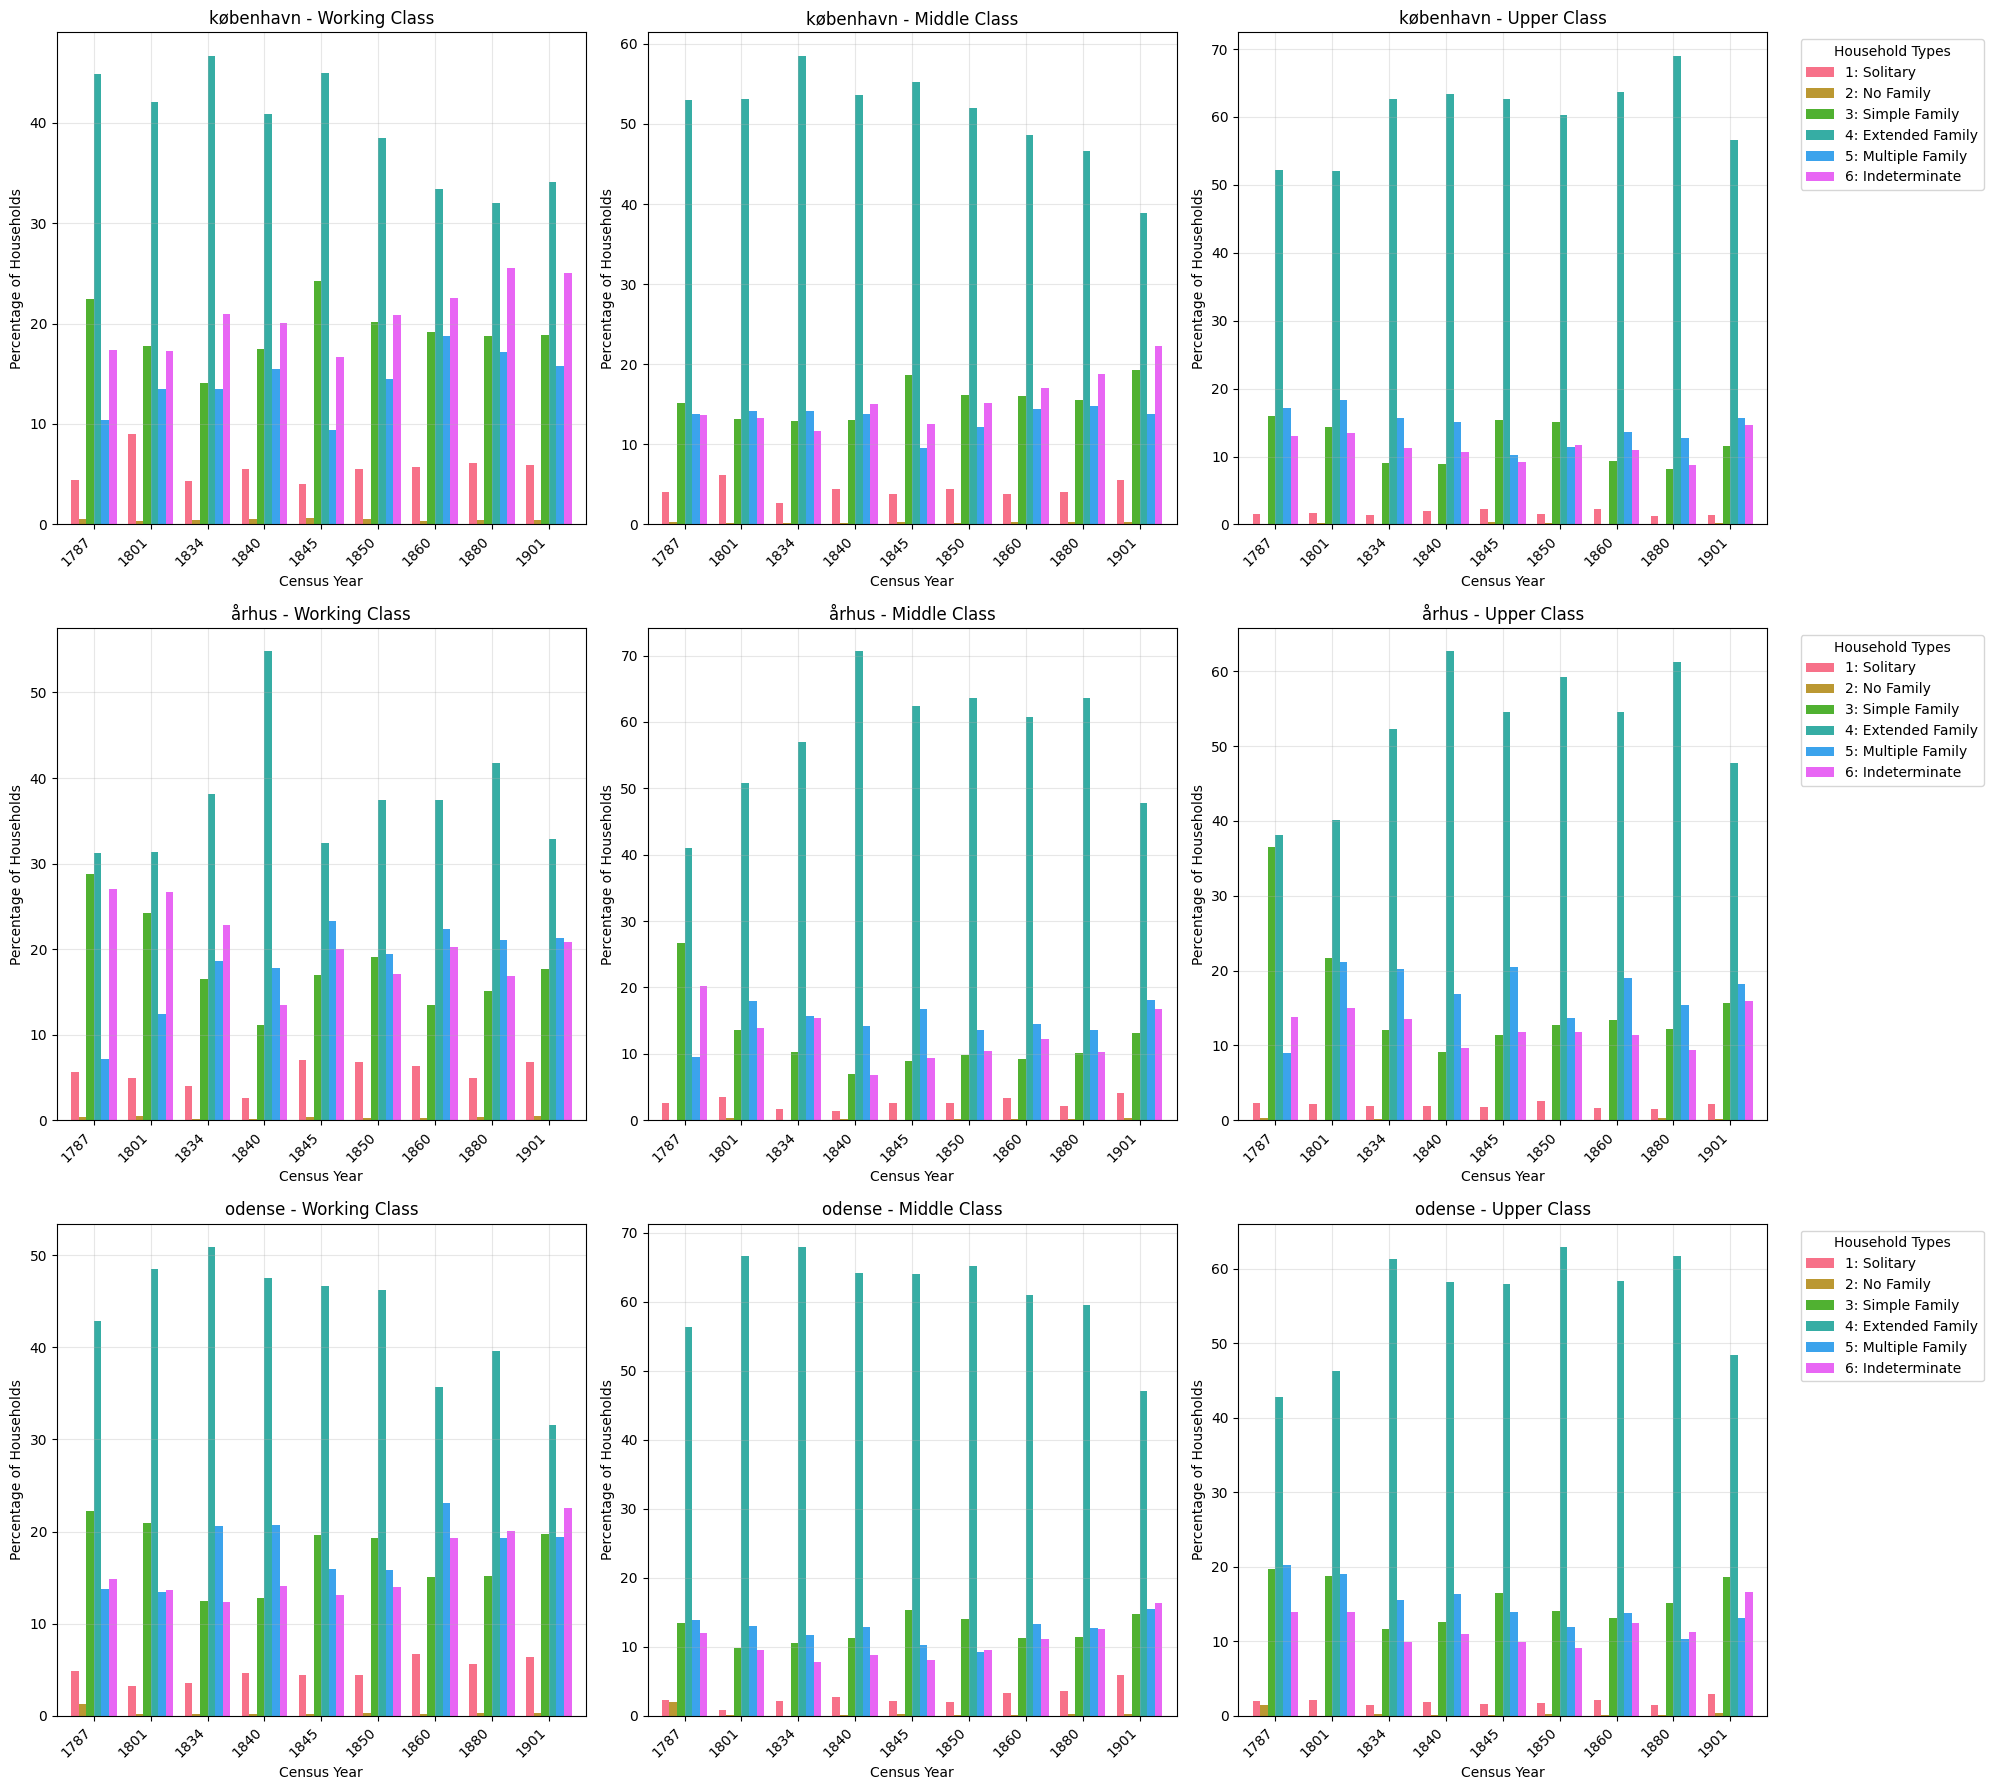

In [3]:
# Analyze the households for each county
county_results = analyze_households_by_county(df_list, county_names)

# Create visualizations
visualize_household_structure_by_county(
    county_results,
    output_path='household_structure_by_county.png'
)

In [4]:
def analyze_social_statistics(enriched_df: pd.DataFrame, county_names: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Calculate comprehensive social statistics using individual-level data with class information.
    
    This function provides a detailed analysis of social class composition by analyzing:
    - Family counts and sizes
    - Demographic composition (women, children, married individuals)
    - Age structures within classes
    - Marriage patterns
    
    Args:
        enriched_df: DataFrame containing individual records with household class information
        county_names: List of county names to analyze
    
    Returns:
        Dictionary containing DataFrames with statistics for each county
    """
    results = {}
    
    # Analyze each county separately
    for county in county_names:
        county_data = enriched_df[enriched_df['event_county'] == county]
        county_results = []
        
        # Process each census year
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            # Calculate statistics for each class
            for class_name in sorted(year_data['class'].unique()):
                if pd.isna(class_name):  # Skip records with no class information
                    continue
                    
                class_data = year_data[year_data['class'] == class_name]
                
                # Count unique families (households)
                family_count = len(class_data['household_id'].unique())
                
                # Count total people without servants.
                total_people = len(class_data[class_data['household_position'] != 'tjeneste'])
                
                # Count children (both by role and age)
                children_by_role = len(class_data[
                    class_data['household_position'].str.contains('børn|barn|datter|søn|son|born', case=False, na=False)
                ])
                children_by_age = len(class_data[class_data['age'] < 15])
                
                # Count adults by gender and marital status
                women_count = len(class_data[class_data['sex'] == 'f'])
                men_count = len(class_data[class_data['sex'] == 'm'])
                married_women = len(class_data[
                    (class_data['sex'] == 'f') & 
                    (class_data['marital_status'] == 'gift')
                ])
                married_men = len(class_data[
                    (class_data['sex'] == 'm') & 
                    (class_data['marital_status'] == 'gift')
                ])
                
                # Calculate age statistics
                mean_age = class_data['age'].mean()
                median_age = class_data['age'].median()
                
                # Calculate household composition metrics
                avg_household_size = total_people / family_count if family_count > 0 else 0
                children_per_household = children_by_role / family_count if family_count > 0 else 0
                
                county_results.append({
                    'year': year,
                    'class': class_name,
                    'family_count': family_count,
                    'total_people': total_people,
                    'children_by_role': children_by_role,
                    'children_by_age': children_by_age,
                    'women_count': women_count,
                    'men_count': men_count,
                    'married_women': married_women,
                    'married_men': married_men,
                    'mean_age': mean_age,
                    'median_age': median_age,
                    'avg_household_size': avg_household_size,
                    'children_per_household': children_per_household,
                    'percent_women_married': (married_women/women_count*100 if women_count > 0 else 0),
                    'percent_men_married': (married_men/men_count*100 if men_count > 0 else 0),
                    'percent_of_total': total_people / len(year_data) * 100
                })
        
        results[county] = pd.DataFrame(county_results)
    
    return results

def print_social_summary(results: Dict[str, pd.DataFrame]) -> None:
    """
    Print a detailed, formatted summary of social statistics
    """
    for county, data in results.items():
        print(f"\n{'='*40}")
        print(f"SOCIAL STATISTICS FOR {county.upper()}")
        print(f"{'='*40}")
        
        # Process each year
        for year in sorted(data['year'].unique()):
            year_data = data[data['year'] == year]
            
            print(f"\nCensus Year: {year}")
            print("-" * 125)
            
            # Basic composition table
            print("\nA. Basic Class Composition")
            print("-" * 100)
            print(f"{'Class':<15} | {'Households':>9} | {'People':>8} | "
                  f"{'% of Pop':>8} | {'Avg Size':>8} | {'Mean Age':>8}")
            print("-" * 100)
            
            for _, row in year_data.iterrows():
                print(f"{str(row['class']):<15} | "
                      f"{row['family_count']:9.0f} | "
                      f"{row['total_people']:8.0f} | "
                      f"{row['percent_of_total']:8.1f} | "
                      f"{row['avg_household_size']:8.1f} | "
                      f"{row['mean_age']:8.1f}")
            
            # Gender and marriage statistics
            print("\nB. Gender and Marriage Statistics")
            print("-" * 115)
            print(f"{'Class':<15} | {'Women':>8} | {'Men':>8} | "
                  f"{'Married W':>9} | {'Married M':>9} | {'% W Marr':>8} | {'% M Marr':>8}")
            print("-" * 115)
            
            for _, row in year_data.iterrows():
                print(f"{str(row['class']):<15} | "
                      f"{row['women_count']:8.0f} | "
                      f"{row['men_count']:8.0f} | "
                      f"{row['married_women']:9.0f} | "
                      f"{row['married_men']:9.0f} | "
                      f"{row['percent_women_married']:8.1f} | "
                      f"{row['percent_men_married']:8.1f}")
            
            # Children statistics
            print("\nC. Children Statistics")
            print("-" * 90)
            print(f"{'Class':<15} | {'By Role':>8} | {'By Age':>8} | "
                  f"{'Per House':>9} | {'% of Class':>9}")
            print("-" * 90)
            
            for _, row in year_data.iterrows():
                children_percent = (row['children_by_role'] / row['total_people'] * 100 
                                 if row['total_people'] > 0 else 0)
                print(f"{str(row['class']):<15} | "
                      f"{row['children_by_role']:8.0f} | "
                      f"{row['children_by_age']:8.0f} | "
                      f"{row['children_per_household']:9.1f} | "
                      f"{children_percent:9.1f}")

def create_class_visualization(results: Dict[str, pd.DataFrame]) -> Dict[str, plt.Figure]:
    """
    Create comprehensive visualizations of social class patterns
    """
    figures = {}
    
    for county, data in results.items():
        # Create figure with six subplots
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2, hspace=0.3)
        
        # 1. Population Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        years = sorted(data['year'].unique())
        classes = sorted(data['class'].unique())
        bottom = np.zeros(len(years))
        
        for class_name in classes:
            values = [data[(data['year'] == year) & 
                          (data['class'] == class_name)]['total_people'].iloc[0]
                     for year in years]
            ax1.bar(years, values, bottom=bottom, label=class_name)
            bottom += np.array(values)
            
        ax1.set_title('Population Distribution by Class')
        ax1.set_ylabel('Number of People')
        ax1.legend()
        
        # 2. Average Household Size
        ax2 = fig.add_subplot(gs[0, 1])
        for class_name in classes:
            values = [data[(data['year'] == year) & 
                          (data['class'] == class_name)]['avg_household_size'].iloc[0]
                     for year in years]
            ax2.plot(years, values, marker='o', label=class_name)
            
        ax2.set_title('Average Household Size by Class')
        ax2.set_ylabel('Average Size')
        ax2.legend()
        
        # 3. Children per Household
        ax3 = fig.add_subplot(gs[1, 0])
        for class_name in classes:
            values = [data[(data['year'] == year) & 
                          (data['class'] == class_name)]['children_per_household'].iloc[0]
                     for year in years]
            ax3.plot(years, values, marker='o', label=class_name)
            
        ax3.set_title('Children per Household by Class')
        ax3.set_ylabel('Average Children')
        ax3.legend()
        
        # 4. Marriage Rates
        ax4 = fig.add_subplot(gs[1, 1])
        for class_name in classes:
            women_values = [data[(data['year'] == year) & 
                                (data['class'] == class_name)]['percent_women_married'].iloc[0]
                           for year in years]
            ax4.plot(years, women_values, marker='o', label=f'{class_name} (Women)')
            
        ax4.set_title('Marriage Rates by Class (Women)')
        ax4.set_ylabel('Percent Married')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5. Mean Age
        ax5 = fig.add_subplot(gs[2, 0])
        for class_name in classes:
            values = [data[(data['year'] == year) & 
                          (data['class'] == class_name)]['mean_age'].iloc[0]
                     for year in years]
            ax5.plot(years, values, marker='o', label=class_name)
            
        ax5.set_title('Mean Age by Class')
        ax5.set_ylabel('Age')
        ax5.legend()
        
        # 6. Class Composition (%)
        ax6 = fig.add_subplot(gs[2, 1])
        bottom = np.zeros(len(years))
        
        for class_name in classes:
            values = [data[(data['year'] == year) & 
                          (data['class'] == class_name)]['percent_of_total'].iloc[0]
                     for year in years]
            ax6.bar(years, values, bottom=bottom, label=class_name)
            bottom += np.array(values)
            
        ax6.set_title('Class Composition (%)')
        ax6.set_ylabel('Percentage')
        ax6.legend()
        
        plt.suptitle(f'Social Class Analysis for {county}', y=1.02, fontsize=16)
        plt.tight_layout()
        figures[county] = fig
        
    return figures

def add_class_to_individual_records(individual_df_list: List[pd.DataFrame], 
                                  classified_households: pd.DataFrame,
                                  county_names: List[str]) -> pd.DataFrame:
    """
    Adds social class information to individual records based on their household_id.
    
    This function takes the classified households dataset and merges it with the
    individual-level data, ensuring each person is associated with their 
    household's social class. The merge is performed using household_id, event_year,
    and event_county as keys to ensure accurate matching across time and space.
    
    Args:
        individual_df_list: List of DataFrames containing individual census records
        classified_households: DataFrame containing household classifications
        county_names: List of county names corresponding to the individual DataFrames
    
    Returns:
        DataFrame containing all individual records enriched with household class information
    """
    # First, combine all individual records into one DataFrame
    for df, county in zip(individual_df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(individual_df_list, ignore_index=True)
    
    # Select only the necessary columns from classified_households
    # to keep the merge efficient and avoid duplicate columns
    households_class_data = classified_households[['household_id', 
                                                 'event_year',
                                                 'event_county',
                                                 'social_class']]
    
    # Merge the class information into the individual records
    # We use a left merge to keep all individuals even if we couldn't classify their household
    enriched_df = combined_df.merge(
        households_class_data,
        on=['household_id', 'event_year', 'event_county'],
        how='left'
    )
    
    # Check for any unmatched records
    unmatched = enriched_df['social_class'].isna().sum()
    total_records = len(enriched_df)
    
    # Print a summary of the merge results
    print(f"\nMerge Summary:")
    print(f"Total individual records: {total_records:,}")
    print(f"Successfully matched with household class: {total_records - unmatched:,}")
    print(f"Unmatched records: {unmatched:,}")
    print(f"Match rate: {((total_records - unmatched) / total_records * 100):.2f}%")
    
    # If there are unmatched records, show some examples to help debugging
    if unmatched > 0:
        print("\nExample of unmatched records:")
        unmatched_examples = enriched_df[enriched_df['social_class'].isna()].head()
        print(unmatched_examples[['household_id', 'event_year', 'event_county']].to_string())

    enriched_df.rename({'social_class': 'class'}, axis='columns', inplace=True)
    
    return enriched_df



In [5]:
# Add class information to individual records
enriched_df = add_class_to_individual_records(df_list, classified_households, county_names)

# Now we can use this enriched DataFrame for our demographic analyses
# It contains all the original individual information plus the household's social class

# Calculate social statistics
social_results = analyze_social_statistics(enriched_df, county_names)

# Print detailed summary
print_social_summary(social_results)

# Create and display visualizations
figures = create_class_visualization(social_results)
for county, fig in figures.items():
    plt.figure(fig.number)
    plt.show()

NameError: name 'classified_households' is not defined